#### <b>RAG Pipeline</b>

In [40]:
#Importing Necessary Libraries

from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq

In [41]:
#Loading Env() Variables

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

##### <b>Data Ingestion (Process 1)</b>

In [42]:
#Imports for Ingestion process
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import FAISS

In [43]:
#Document Loading
loader = PyPDFLoader(r"C:\Users\bharath.sr.lv\Desktop\Agentic AI -LP\LV_AgenticAILearningPath\RAG_Approach\budget_speech.pdf")

raw_data = loader.load()

print(raw_data[12].page_content)

9  
 
Bharatiya Bhasha Pustak Scheme 
43. We propose to implement a Bharatiya Bhasha Pustak Scheme to 
provide digital-form Indian language books for school and higher education. 
This aims to help students understand their subjects better.  
National Centres of Excellence for Skilling 
44. Building on the initiative announced in the July 2024 Budget, five 
National Centres of Excellence for skilling will be set up with global expertise 
and partnerships to equip our youth with the skills required for “Make for India, 
Make for the World” manufa cturing. The partnerships will cover curriculum 
design, training of trainers, a skills certification framework, and periodic 
reviews. 
Expansion of Capacity in IITs 
45. Total number of students in 23 IITs has increased 100 per cent from 
65,000 to 1.35 lakh in the past 10 years. Additional infrastructure will be 
created in the 5 IITs started after 2014 to facilitate education for 6,500 more 
students. Hostel and other infra structure capaci

In [44]:
#Metadata for the split document
import pprint

pprint.pp(raw_data[12].metadata)

{'producer': 'Microsoft® Word 2021',
 'creator': 'Microsoft® Word 2021',
 'creationdate': '2025-02-01T03:54:26+05:30',
 'author': 'hss',
 'moddate': '2025-02-01T03:56:01+05:30',
 'title': '',
 'source': 'C:\\Users\\bharath.sr.lv\\Desktop\\Agentic AI '
           '-LP\\LV_AgenticAILearningPath\\RAG_Approach\\budget_speech.pdf',
 'total_pages': 60,
 'page': 12,
 'page_label': '13'}


Chunking

In [45]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 50)

chunks = text_splitter.split_documents(raw_data)
print(chunks[2].page_content)

Budget 2025-2026 
 
Speech of 
Nirmala Sitharaman 
Minister of Finance 
February 1, 2025 
Hon’ble Speaker,  
 I present the Budget for 2025-26. 
Introduction 
1. This Budget continues our Government’s efforts to: 
a) accelerate growth,  
b) secure inclusive development,  
c) invigorate private sector investments,  
d) uplift household sentiments, and 
e) enhance spending power of India’s rising middle class.  
2. Together, we embark on a journey to unlock our nation’s tremendous


Storing the chunks

In [46]:
#vector store Imports
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

In [47]:
#creating embeddings for the chunks
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vector_store = FAISS.from_documents(chunks,embeddings)

In [48]:
#create a Retriever
retriever = vector_store.as_retriever()

In [49]:
from langchain.prompts import ChatPromptTemplate

prompt_template = '''
You are an AI assistant that answers user questions based on the provided document excerpts.  
The excerpts are retrieved from a PDF. Always ground your answers in the given context.  

If the answer cannot be found in the excerpts, say:  
"I couldn’t find this information in the provided document."  

---
📘 Context (from PDF):
{context}

---
User Question:
{question}

---
Instructions for Answering:
1. Use only the information in the provided context.  
2. Do not fabricate or add external knowledge.  
3. If multiple excerpts give partial answers, combine them concisely.  
4. If the context does not contain the answer, clearly state it.  
5. Provide the final answer in a clear and well-structured format.
'''

prompt = ChatPromptTemplate.from_template(prompt_template)

##### <b>Retrieval And Generation</b>

In [53]:
#Imports for building chain
from langchain_groq import ChatGroq
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser 

llm =  ChatGroq(
    model = "gemma2-9b-it",
    temperature = 0.2, 
    max_completion_tokens=1024
)

output_parser = StrOutputParser()

c:\Users\bharath.sr.lv\Desktop\Agentic AI -LP\AgenticAIlp\lib\site-packages\langchain_groq\chat_models.py:370: UserWarning: WARNING! max_completion_tokens is not default parameter.
                    max_completion_tokens was transferred to model_kwargs.
                    Please confirm that max_completion_tokens is what you intended.
  warnings.warn(


In [54]:
#Chain creation

rag_chain = (
    {"context":retriever, "question": RunnablePassthrough()}
    |prompt
    |llm
    |output_parser
    )

#### Test

In [57]:
print(rag_chain.invoke("What is the tax slab for the current year for salaried people?"))

APIConnectionError: Connection error.

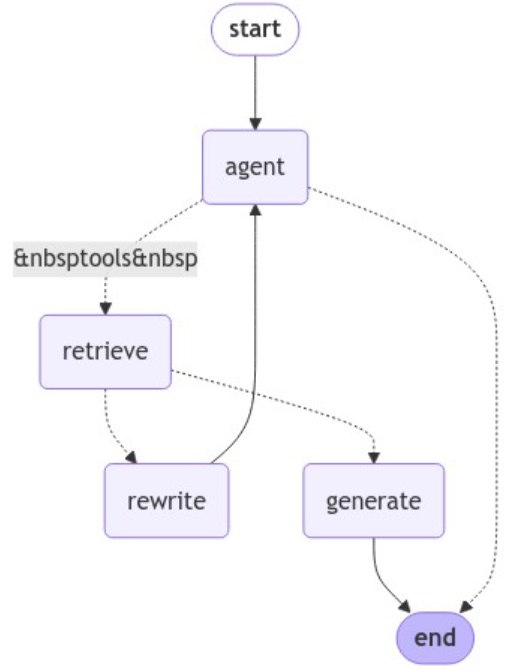